Loading the embedding data (train and test) for running a logistic regression model and evaluating the test set to observe the results.


In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
from google.colab import drive
drive.mount('/content/drive')  # חייב להריץ שוב במחברת החדשה

load_path = '/content/drive/MyDrive/my_embeddings_folder_cubes/'

X_train = np.load(load_path + 'best_train_embeddings.npy')
y_train = np.load(load_path + 'train_labels.npy')
X_test = np.load(load_path + 'test_embeddings.npy')
y_test = np.load(load_path + 'test_labels.npy')
# === Load best transform name (for display)
with open(load_path + 'best_transform_name.txt', 'r') as f:
    best_transform_name = f.read().strip()

Mounted at /content/drive


Using a classification model - logistic regression. Testing the results using a confusion matrix.

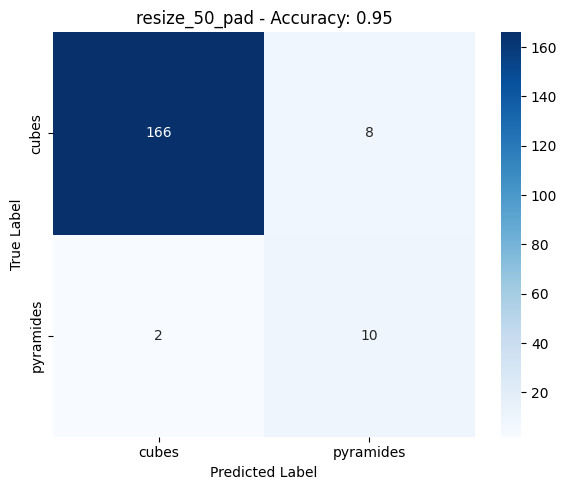


📋 Classification Report for resize_50_pad:

              precision    recall  f1-score   support

       cubes       0.99      0.95      0.97       174
   pyramides       0.56      0.83      0.67        12

    accuracy                           0.95       186
   macro avg       0.77      0.89      0.82       186
weighted avg       0.96      0.95      0.95       186



In [ ]:
# === Encode labels
le = LabelEncoder()
y_train_encoded = le.fit_transform(y_train)
y_test_encoded = le.transform(y_test)

# === Train model
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train_encoded)

# === Predict and evaluate
y_pred = model.predict(X_test)
acc = accuracy_score(y_test_encoded, y_pred)
cm = confusion_matrix(y_test_encoded, y_pred)

# === Plot Confusion Matrix
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.title(f"{best_transform_name} - Accuracy: {acc:.2f}")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.tight_layout()
plt.show()

# === Classification Report
report = classification_report(y_test_encoded, y_pred, target_names=le.classes_)
print(f"\n📋 Classification Report for {best_transform_name}:\n")
print(report)

In [ ]:
def visualize_predictions_with_bboxes(full_image_path, file_paths, predicted_labels, save_path):
    """
    Draws boxes around objects in the image according to the model's predictions.

    Parameters:
    - full_image_path: str, the path to the full image (background)
    - file_paths: list of str, paths to the cropped images (names include coordinates)
    - predicted_labels: list of str/int, the model's predictions (labels)
    - save_path: str, the path to save the image with the boxes
    """
    import cv2
    import re
    import numpy as np
    import matplotlib.pyplot as plt
    import os

    full_image = cv2.imread(full_image_path)
    image_copy = full_image.copy()
    pattern = re.compile(r"cubes_test_(\d+)_(\d+)_(\d+)_(\d+)\.jpg")

    colors = {
            "cubes": (0, 255, 0),      # green
            "pyramides": (225, 0, 0),  # blue
        }

    legend_height = 30 * len(colors)
    legend_width = 200
    legend_img = np.ones((legend_height, legend_width, 3), dtype=np.uint8) * 255

    for i, label in enumerate(colors):
        color = colors[label]
        cv2.rectangle(legend_img, (10, i*30 + 10), (30, i*30 + 30), color, -1)
        cv2.putText(legend_img, f"Class {label}", (40, i*30 + 25),
                   cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1, cv2.LINE_AA)

    for file_path, label in zip(file_paths, predicted_labels):
        filename = os.path.basename(file_path)
        match = pattern.match(filename)
        if match:
            x1, y1, x2, y2 = map(int, match.groups())
            color = colors[label]
            overlay = image_copy.copy()
            cv2.rectangle(overlay, (x1, y1), (x2, y2), color, 2)
            alpha = 1.4
            cv2.addWeighted(overlay, alpha, image_copy, 1 - alpha, 0, image_copy)

    cv2.imwrite(save_path, image_copy)
    image_rgb = cv2.cvtColor(image_copy, cv2.COLOR_BGR2RGB)
    legend_rgb = cv2.cvtColor(legend_img, cv2.COLOR_BGR2RGB)

    fig, ax = plt.subplots(1, 2, figsize=(15, 8), gridspec_kw={'width_ratios': [4, 1]})
    ax[0].imshow(image_rgb)
    ax[0].set_title("Image with Bounding Boxes")
    ax[0].axis('off')

    ax[1].imshow(legend_rgb)
    ax[1].set_title("Class Legend")
    ax[1].axis('off')

    plt.tight_layout()
    plt.show()
    print(f"Saved image with bounding boxes to: {save_path}")


Creating bounding boxes (BBOX) for the test set based on the results


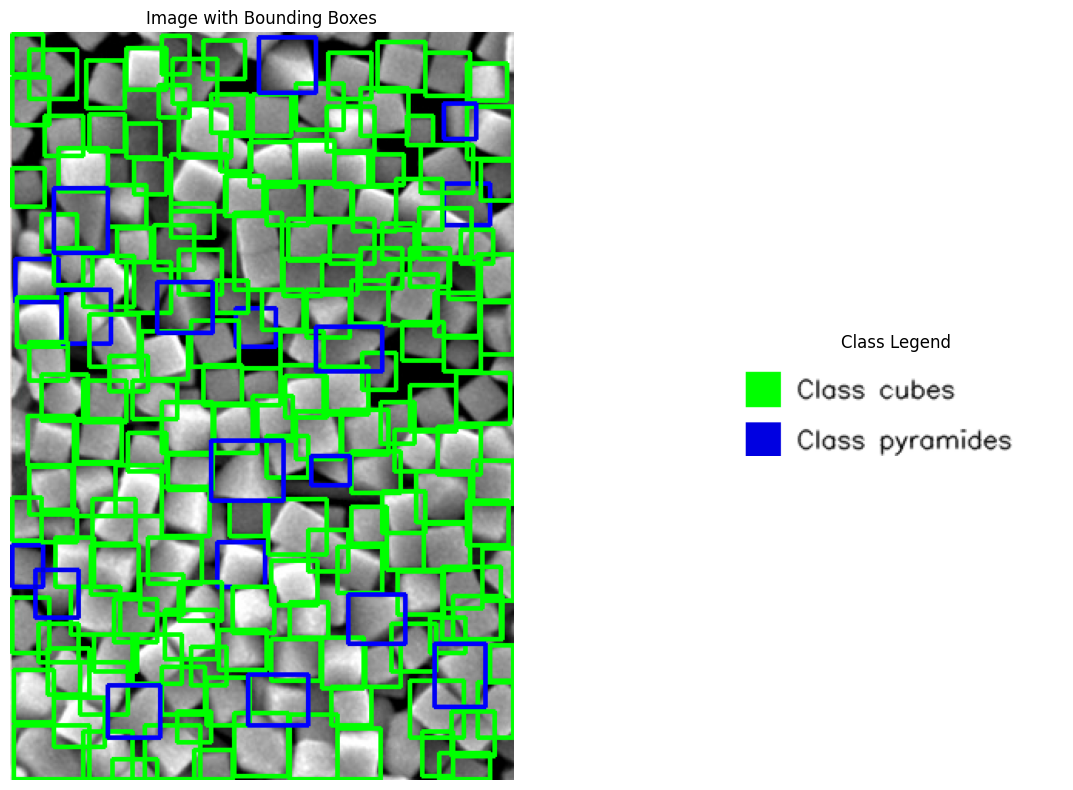

Saved image with bounding boxes to: drive/MyDrive/full_image_with_bboxes_cubes.jpg


In [ ]:
import os
def get_image_paths(dirpath):
    out=[]
    for cl in os.listdir(dirpath):
        cp=os.path.join(dirpath,cl)
        if os.path.isdir(cp):
            out += [os.path.join(cp,f) for f in os.listdir(cp) if f.lower().endswith(('.jpg','.png','.jpeg'))]
    return out

test_image_paths = get_image_paths("/content/drive/MyDrive/cubes_new/test")
visualize_predictions_with_bboxes(
    full_image_path="drive/MyDrive/cubes_test_.jpg",
    save_path="drive/MyDrive/full_image_with_bboxes_cubes.jpg",
    file_paths= test_image_paths,
    predicted_labels=le.inverse_transform(y_pred))